# Session 6: LLM-Based Emotion Analysis  

With the advent of large language models (LLMs), particularly the transformer based LLMs such as BERT, LLAMA, Gemini etc., NLP community has tapped into these models for developing new techniques and methodologies for a wide range of NLP tasks. One key NLP task that can benefit from such resources is the Emotion Analysis, which is a highly challenging NLP task.  In this tutorial, we will learn and practice how to tune three LLMs including BERT, RoBERTa, T5 and use them to classify emotion of some social media messages. Sample training and testing data will be provided which derive from publicly available GoEmotion corpus, and we will test classifying text using two emotion classification schemes: GoEmotion Scheme (27 emotion categories) and Ekman’s scheme (6 categories). The GoEmotion emotion categories can be mapped into Ekman’s categories.  

This tutorial will guide you on how to tune LLMs for emotion classification based on the two emotion schemes. To tune LLMs, we need to consider the charecteristics of each LLMs. For BERT and RoBERTa, they are similar which we need to connect them to the classification layer. On the other, T5 can generate text meaning we can ask the model directly by giving it an questions. Therefore, we do not need to create a classification layer for T5.  

There are three mains step for tuning LLMs. The first step involves preparing data and setingup datamodule for tuning process. The second step is about creating tuning process. The final step is to review the tuning process by visualising tuning stats, then save the model. We break down these three step as follows:  

1. Preparing data  
1.1 Load data from files  
1.2 Setup datamodule  
2. Tuning process   
2.1 Setup tuning process    
2.2 Setup parameters and load model/tokeniser  
2.3 Tune and test the model  
3. Review tuning stat    
3.1 Visualise tuning stat  
3.2 Save the model  


***

## Emotion classification based on BERT  

In this section, we will show you how to tune BERT according to the steps expained previously. We will first classify emotion based on Ekman's scheme. Then we will look at how to classify emotion based on the GoEmotion scheme.  

Let's begin..  
The first step is to prepare the data. Sample dataset is store in 'sample_data'. In the folder, you will find train, val, and test data used for training, validating, and testing respectively. The data is in csv format.  

The code used for loading the data to our program is shown below. 

In [1]:
import pandas as pd

traindf = pd.read_csv("./sample_data/train.csv")
valdf = pd.read_csv("./sample_data/val.csv")
testdf = pd.read_csv("./sample_data/test.csv")

len(traindf), len(valdf), len(testdf)

(2663, 511, 508)

After data is loaded, we print out the data stat. The above output shows the lengths of data which are 2663, 511, and 508 for train, validate, and test data respectively. Next, let's look at data sample of the train data.

In [2]:
traindf

,text,go_index,go_label,ekman_label,ekman_index
0,[NAME] breaks to love early in the third.,27,neutral,neutral,4
1,Wait what planet was this on? I dont remember ...,27,neutral,neutral,4
2,And then everyone clapped,27,neutral,neutral,4
3,Yea. From my estimation I have about 5 years b...,27,neutral,neutral,4
4,we're getting our top men right on that.,27,neutral,neutral,4
...,...,...,...,...,...
2658,Edgy bro.,19,nervousness,fear,2
2659,Everytime I see something in this sub that loo...,19,nervousness,fear,2
2660,"60 young men standing around... ""Look out that...",19,nervousness,fear,2
2661,I am getting so nervous watching this,19,nervousness,fear,2


The train data contain 5 columns. The go_label and ekman_label columns are emotion label of text, and go_index and ekman_index columns are emotion category in number format. For emotion classification based on BERT, we are going to use the index as labels. Thus, the below code indicates the data column and class column for later use.  

In [3]:
DATALABEL = 'text'
CLASSLABEL = 'ekman_index'
f"number of emotion categories: {len(traindf[CLASSLABEL].value_counts())}"

'number of emotion categories: 7'

After finished loading the data, it is time to setup the datamodule. In training or tuning LLMs, one round of training or tuning session is called epoch, where in each epoch we break the whole data down in to small batch. Here is what datamodule does, it fasilitate the tunging process by providing model with batch of data in each epoch.  

To implement datamodule, we use torch and pytorch lightning packages as shown below.

In [4]:
from torch.utils.data import DataLoader, Dataset
import torch

class EmoDataset(Dataset):
    def __init__(self, df, tokenizer, max_length, datalabel, classlabel):
        self.data = df
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.texts = self.data[datalabel].tolist()
        self.labels = self.data[classlabel].tolist()

    def __len__(self):
        return(len(self.texts))

    def __getitem__(self,idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(text,
                                              max_length = self.max_length,
                                              add_special_tokens = True,
                                              padding = 'max_length',
                                              truncation = True,
                                              return_attention_mask = True,
                                              return_tensors = 'pt',
                                              )

        return {'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label),
                }

The above code is to create a dataset using torch Dataset. The next step is to create datamodule, in which provides batch data for tuning process. 

In [5]:
import pytorch_lightning as pl

class EmoDataModule(pl.LightningDataModule):
    def __init__(self, traindf, valdf, testdf, batch_size, tokenizer, max_length, datalabel, classlabel):
        super().__init__()
        self.traindf = traindf
        self.valdf = valdf
        self.testdf = testdf
        self.datalabel = datalabel
        self.classlabel = classlabel
        # parameters
        self.batch_size = batch_size
        self.max_length = max_length
        # tokenizer
        self.tokenizer = tokenizer
    
    def setup(self, stage=None):
        self.train_dataset = EmoDataset( self.traindf, self.tokenizer, self.max_length, self.datalabel, self.classlabel)
        self.val_dataset = EmoDataset( self.valdf, self.tokenizer, self.max_length, self.datalabel, self.classlabel)
        self.test_dataset = EmoDataset( self.testdf, self.tokenizer, self.max_length, self.datalabel, self.classlabel)
    
    def train_dataloader(self):
        return DataLoader( self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader( self.val_dataset, batch_size=self.batch_size)
        
    def test_dataloader(self):
        return DataLoader( self.test_dataset, batch_size=self.batch_size)

Now the data is ready.
***

Tuning process  

Now, the datamodule is ready. The next step is to create a tuning process. As we use BERT, we need to create a classification layer and connect it the BERT. This example will show you how to create and connect it to BERT. We will implement this using pytorch lightning by creating a simple model with structure as follows:  

BERT  
Linear layer  
ReLU  
Drop out layer  
Classifier layer  
CrossEntropyLoss  

The code below show the implementation.
  


In [6]:
from torch import nn
from transformers import AdamW, get_linear_schedule_with_warmup

class EmoClassifier(pl.LightningModule):
    def __init__(self, model, num_class, learning_rate, epoch, train_size):
        super(EmoClassifier, self).__init__()
        self.model = model
        self.num_class = num_class
        self.learning_rate = learning_rate
        self.epoch = epoch
        self.train_size = train_size
        self.pre_classifier = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, self.num_class)


    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
        pooler = outputs[0][:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        logits = self.classifier(pooler)

        return logits
  
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        logits = self(input_ids, attention_mask)
        _, preds = torch.max(logits, dim = 1)
        loss = nn.CrossEntropyLoss()(logits, labels)

        self.log('train_loss', loss, on_epoch=True)
        self.log('train_acc',(preds == labels).sum() / len(labels), on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]

        logits = self(input_ids, attention_mask)
        _, preds = torch.max(logits, dim = 1)
        loss = nn.CrossEntropyLoss()(logits, labels)

        self.log('val_loss', loss)
        self.log('val_acc', (preds == labels).sum() / len(labels))
        return loss
 
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]
        logits = self(input_ids=input_ids, 
                      attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(logits, labels)
        _, preds = torch.max(logits, dim = 1)

        self.log('test_loss', loss)
        self.log('test_acc', (preds == labels).sum() / len(labels))


    
    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.learning_rate)
        scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=0,
                num_training_steps=self.epoch*self.train_size)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

The tuning loop is ready. We will load the model and setup parameters for tuning. In our example, we use BERT model named "bert-base-uncased" available on huggingface website. We load it using transformers package.

In [7]:
from transformers import BertModel
from transformers import BertTokenizer

MODEL = BertModel.from_pretrained("bert-base-uncased")
TOKENIZER = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

The parameters of tunging process are shown in the below code. These parameters can be adjusted.

In [8]:
EPOCH = 2
CLASSES = 7 # emotion in ekman is 6 + 1 neutral
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
TRAIN_SIZE = len(traindf)
MAX_LENGTH = TOKENIZER.model_max_length #512

Before tuning the model, we need to record the tuning stat. In out case, we use CSVLogger for the job. We save the log file to "./logs/BERT_exp" directory. 

In [9]:
from lightning.pytorch.loggers import CSVLogger

logger = CSVLogger("./logs", name='BERT_exp', version=1)

Now everything is ready. We will start tuning!!!

In [12]:
# call for datamudule
EkmanDatamodule = EmoDataModule(traindf=traindf,
                               valdf=valdf,
                               testdf=testdf,
                               tokenizer=TOKENIZER,
                               batch_size=BATCH_SIZE,
                               max_length=MAX_LENGTH,
                               datalabel=DATALABEL,
                               classlabel=CLASSLABEL)
# call setup function
EkmanDatamodule.setup()

# get the classifier
BERTcls = EmoClassifier(
    model=MODEL,
    num_class=CLASSES,
    learning_rate=LEARNING_RATE,
    epoch=EPOCH,
    train_size=TRAIN_SIZE
)

# print the model structure
BERTcls

EmoClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

The tuning is finish. We can test the model and procedd to the visualisation step.

In [13]:
# using pytorch trainer for tuning
trainer = pl.Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=EPOCH,
    precision="16-mixed",
    logger=logger)

# start tuning
trainer.fit(BERTcls, EkmanDatamodule)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
e:\miniconda3\envs\phdenv\Lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory ./logs\BERT_exp\version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory ./logs\BERT_exp\version_1\checkpoints exists and is not empty.
LOC

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
e:\miniconda3\envs\phdenv\Lib\site-packages\transformers\models\bert\modeling_bert.py:435: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [14]:
trainer.test(BERTcls, EkmanDatamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7224409580230713
        test_loss           0.8925064206123352
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8925064206123352, 'test_acc': 0.7224409580230713}]

We can see the performance of emotion classification above. 

***
Review tuning stat  
As mentioned, the log will be saved in './logs/BERT_exp' directory. The log file is 'metrics.csv'. We can open the file and have a look.

In [15]:
metrices = pd.read_csv('./logs/BERT_exp/version_1/metrics.csv')
metrices.head(10)

,epoch,step,test_acc,test_loss,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,val_acc,val_loss
0,0,49,NaN,NaN,NaN,0.625,NaN,1.189270,NaN,NaN
1,0,99,NaN,NaN,NaN,0.375,NaN,1.436707,NaN,NaN
2,0,149,NaN,NaN,NaN,0.625,NaN,0.900208,NaN,NaN
3,0,199,NaN,NaN,NaN,0.500,NaN,1.359833,NaN,NaN
4,0,249,NaN,NaN,NaN,0.625,NaN,1.174881,NaN,NaN
5,0,299,NaN,NaN,NaN,0.750,NaN,1.272186,NaN,NaN
6,0,332,NaN,NaN,NaN,NaN,NaN,NaN,0.727984,0.919041
7,0,332,NaN,NaN,0.583177,NaN,1.252738,NaN,NaN,NaN
8,1,349,NaN,NaN,NaN,0.750,NaN,0.942421,NaN,NaN
9,1,399,NaN,NaN,NaN,0.875,NaN,0.504105,NaN,NaN


The data is hard to read. We want to see training loss and performance, as well as valitaion loss and performance. So, let's get the stats.

In [16]:
def GetTuningStats(metrices):
    training_metric = metrices[['train_acc_epoch','train_loss_epoch']].dropna().reset_index(drop=True)
    validate_metric = metrices[['val_acc','val_loss']].dropna().reset_index(drop=True)
    testing_metric = metrices[['test_acc']].dropna().reset_index(drop=True)
    merge_matrices = pd.merge(training_metric,validate_metric, left_index=True, right_index=True)
    return testing_metric, merge_matrices


In [17]:
test_performance, tuning_stats = GetTuningStats(metrices)

In [18]:
# save the test result for later comparison
results = {} 
results['bert_ekman'] = test_performance.test_acc.to_list()[0]
results

{'bert_ekman': 0.7224409580230713}

In [19]:
tuning_stats

,train_acc_epoch,train_loss_epoch,val_acc,val_loss
0,0.583177,1.252738,0.727984,0.919041
1,0.796846,0.684264,0.747554,0.866035


The tables are still not easy to read. Let's merge them and plot.

<Axes: >

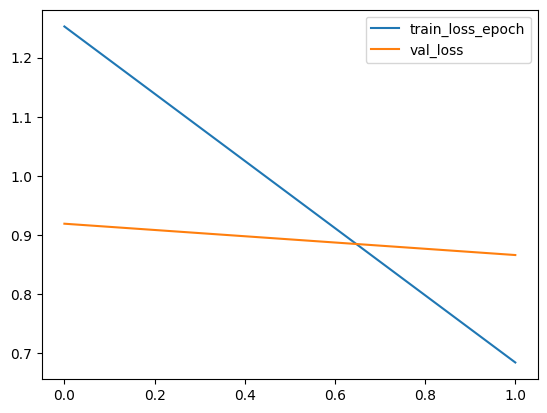

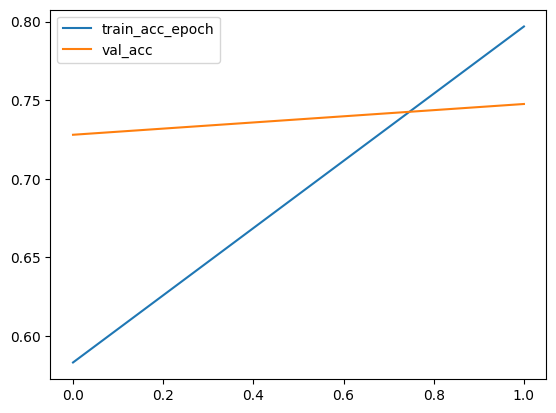

In [20]:
# losses of each epoch
tuning_stats[['train_loss_epoch','val_loss']].plot()
# accuracy of each epoch
tuning_stats[['train_acc_epoch','val_acc']].plot()

According to the visulisation, the model is doing fine. If you want to save the model for later use, below are the code for saving and loading model.  

In [21]:
# saving
torch.save(BERTcls.state_dict(), './tuned_models/bert.pt')

In [20]:
# loading
saved_model = EmoClassifier(
    model=MODEL,
    num_class=CLASSES,
    learning_rate=LEARNING_RATE,
    epoch=EPOCH,
    train_size=TRAIN_SIZE
)
saved_model.load_state_dict(torch.load('./tuned_models/bert.pt'))
saved_model.eval()

EmoClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

***

We have done emotion classification based on Ekman' scheme (7 emotion categories). Next let's try emotion classification based on GoEmotion scheme.  

First let's look at the data again.

In [22]:
traindf.head(5)

,text,go_index,go_label,ekman_label,ekman_index
0,[NAME] breaks to love early in the third.,27,neutral,neutral,4
1,Wait what planet was this on? I dont remember ...,27,neutral,neutral,4
2,And then everyone clapped,27,neutral,neutral,4
3,Yea. From my estimation I have about 5 years b...,27,neutral,neutral,4
4,we're getting our top men right on that.,27,neutral,neutral,4


In Ekman classification, we used ekman_index column as emotion label. This time we will use go_index column instead. Let's set the datalabel and classlable columns.  

In [23]:
DATALABEL = 'text'
CLASSLABEL = 'go_index'
f"number of emotion categories: {len(traindf[CLASSLABEL].value_counts())}"

'number of emotion categories: 28'

The data based on GoEmotion scheme contains 28 emotion categories. To classify and tune the model for GoEmotion scheme, first we need to create new datamodule. This datamodule will contain messages with GoEmotion labels. We can reuse defined functions above. 

In [24]:
# call for datamudule
GoEmotionDatamodule = EmoDataModule(traindf=traindf,
                               valdf=valdf,
                               testdf=testdf,
                               tokenizer=TOKENIZER,
                               batch_size=BATCH_SIZE,
                               max_length=MAX_LENGTH,
                               datalabel=DATALABEL,
                               classlabel=CLASSLABEL)
# call setup function
GoEmotionDatamodule.setup()

Before we do the tuning, some parameters will have to change, such as number of classes. During the ekman's scheme classification, the number of classes was 6. However, now the GoEmotion scheme contain 28 emotion categories. Therefore we change it accordingly and start tuning!!

In [25]:
# change number of classes 
CLASSES = 28

# get the new classifier
BERTcls = EmoClassifier(
    model=MODEL,
    num_class=CLASSES,
    learning_rate=LEARNING_RATE,
    epoch=EPOCH,
    train_size=TRAIN_SIZE
)

# before tuning set log directory for this tuning process 
logger = CSVLogger("./logs", name='BERT_exp_goemotion', version=1)

# now tune the model
trainer = pl.Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=EPOCH,
    precision="16-mixed",
    logger=logger)

# start tuning
trainer.fit(BERTcls, GoEmotionDatamodule)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
e:\miniconda3\envs\phdenv\Lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory ./logs\BERT_exp_goemotion\version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory ./logs\BERT_exp_goemotion\version_1\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\miniconda3\envs\phdenv\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [26]:
trainer.test(BERTcls, GoEmotionDatamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5255905389785767
        test_loss           1.9522426128387451
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.9522426128387451, 'test_acc': 0.5255905389785767}]

After finished tuning and testing, let's look at the tuning metrices.

In [27]:
metrices = pd.read_csv('./logs/BERT_exp_goemotion/version_1/metrics.csv')
test_perm , tuning_stats = GetTuningStats(metrices)
test_perm

,test_acc
0,0.525591


Let's plot the tune stats

<Axes: >

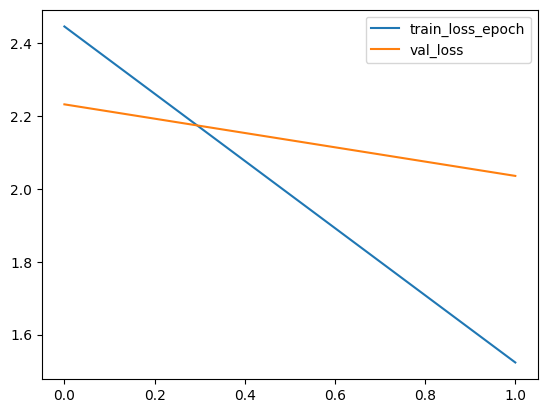

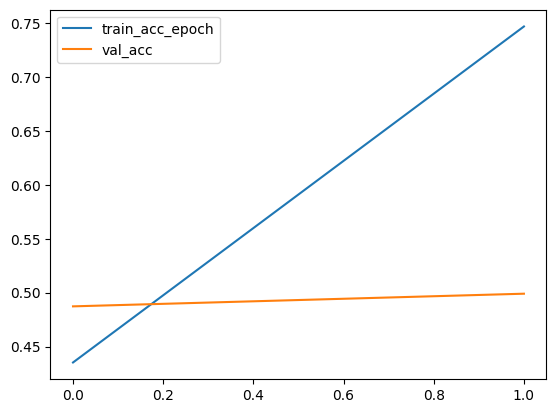

In [28]:
tuning_stats[['train_loss_epoch','val_loss']].plot()
tuning_stats[['train_acc_epoch','val_acc']].plot()

Let's compare the performance of the two classification based on the two schemes (Ekman's and GoEmotion)

In [29]:
results['bert_goemo'] = test_perm.test_acc.to_list()[0]
results

{'bert_ekman': 0.7224409580230713, 'bert_goemo': 0.5255905389785767}

We can see that the performance based on Ekman's scheme is better. This might due to the number of emotion categories, of which Ekman's is less than that of GoEmotion's.

***

## Emotion classification based on RoBERTa  

Until now, we have some experience of how to classify emotion and tune the BERT model based on the two emotion schemes. The next example will show you how to use RoBERTa model.  

RoBERTa is quite similar to BERT in term of implementing. Meaning we can reuse the defined functions. However, the difference is we need change our 'MODEL' to RoBERTa model. The code below shows how to load RoBERTa model and its tokeniser. 

In [30]:
from transformers import RobertaModel
from transformers import RobertaTokenizer


MODEL = RobertaModel.from_pretrained("roberta-base")
TOKENIZER = RobertaTokenizer.from_pretrained("roberta-base")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We have loaded RoBERTa model named 'roberta-based' and its tokeniser. We will tune RoBERTa based emotion classifier on the GoEmotion scheme. Similary, we can use the same parameters and functions as follows:

In [31]:
# check the model input length. 
# same as BERT 512
TOKENIZER.model_max_length

512

Create emotion classifier and print it for checking

In [32]:
CLASSES = 7
RobertaCls = EmoClassifier(
    model=MODEL,
    num_class=CLASSES,
    learning_rate=LEARNING_RATE,
    epoch=EPOCH,
    train_size=TRAIN_SIZE
)
RobertaCls

EmoClassifier(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

Our emotion classifier is using RoBERTa. Let's start tuning.

In [33]:
# save the tuning stats to 'RoBERTa_exp' directory
logger = CSVLogger("./logs", name='RoBERTa_exp', version=1)

trainer = pl.Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=EPOCH,
    precision="16-mixed",
    logger=logger)

trainer.fit(RobertaCls, EkmanDatamodule)
trainer.test(RobertaCls, EkmanDatamodule)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
e:\miniconda3\envs\phdenv\Lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory ./logs\RoBERTa_exp\version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory ./logs\RoBERTa_exp\version_1\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\miniconda3\envs\phdenv\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name        

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.4921259880065918
        test_loss           1.5104585886001587
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.5104585886001587, 'test_acc': 0.4921259880065918}]

In [35]:
metrices = pd.read_csv('./logs/RoBERTa_exp/version_1/metrics.csv')
test_perm , tuning_stats = GetTuningStats(metrices)
test_perm

,test_acc
0,0.492126


<Axes: >

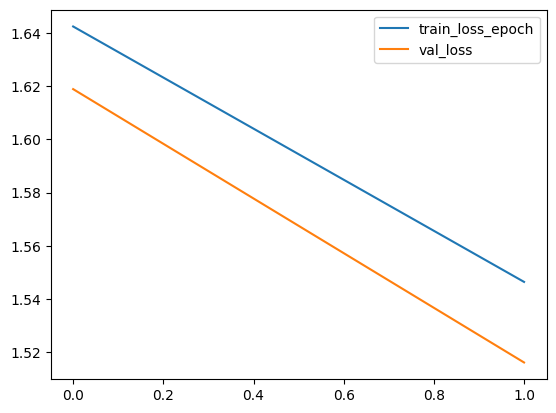

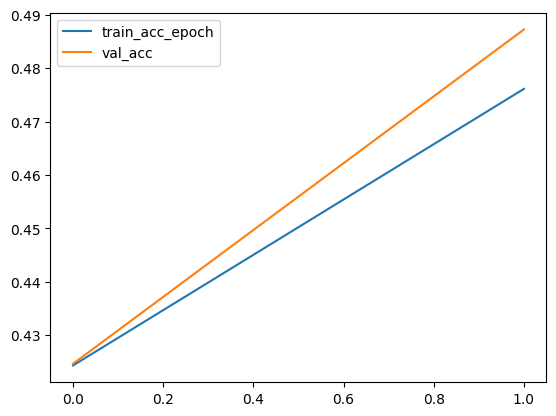

In [36]:
tuning_stats[['train_loss_epoch','val_loss']].plot()
tuning_stats[['train_acc_epoch','val_acc']].plot()

Let's compare the performance between BERT and RoBERTa emotion classifiers based on GoEmotion scheme.

In [40]:
results['roberta_ekman'] = test_perm.test_acc.to_list()[0]
results

{'bert_ekman': 0.7224409580230713,
 'bert_goemo': 0.5255905389785767,
 'roberta_ekman': 0.4921259880065918}

The tuned model can be saved/loaded using the similar approach as BERT based classifier.

In [41]:
torch.save(RobertaCls.state_dict(), './tuned_models/roberta.pt')

In [37]:
saved_model = EmoClassifier(
    model=MODEL,
    num_class=CLASSES,
    learning_rate=LEARNING_RATE,
    epoch=EPOCH,
    train_size=TRAIN_SIZE
)
saved_model.load_state_dict(torch.load('./tuned_models/roberta.pt'))
saved_model.eval()

EmoClassifier(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

This tutorial has shown you how to tune BRET and RoBRETa based classifiers for emotion classification. There are many approaches of how to improve the performance of the models, in which needs to be explored. For example, using more complex classifier layer after the LLMs or using different parameters (batch_size, learning_rate, etc.).  

Good luck on exploring!!  
***

## Emotion classification based on T5  
In the previous sections, we learned how to tune BERT and RoBERTa for emotion calssification based on the two different emotion schemes. This section will show an example of how to tune T5 model for emotion classification. Unlike BERT and RoBERTa, T5 is text-generated model, which mean we can give instruction to the model to follow. Therefore, our input will include intruction for the model as follows:  

"{instruction}: {text}" -> "emotion classification: Today is a good day." 

From the above input, we add instruction before the actual input text, i.e. emotion classification followed by text of which we want to classify.  

With this concept, let's start implementing.




In [42]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

MODEL = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict=True)
TOKENIZER = T5Tokenizer.from_pretrained("t5-small")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

e:\miniconda3\envs\phdenv\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\font-\.cache\huggingface\hub\models--t5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


We have loaded T5 model named "T5-small". As T5 generated text, we want it to generate emotion categories as output rather than emotion index. So, let's look at the data again.

In [43]:
traindf.head(5)

,text,go_index,go_label,ekman_label,ekman_index
0,[NAME] breaks to love early in the third.,27,neutral,neutral,4
1,Wait what planet was this on? I dont remember ...,27,neutral,neutral,4
2,And then everyone clapped,27,neutral,neutral,4
3,Yea. From my estimation I have about 5 years b...,27,neutral,neutral,4
4,we're getting our top men right on that.,27,neutral,neutral,4


We will start with Ekman scheme. The datalabel is the same in text column. However, emotion categories are in ekman_label column. 

In [44]:
DATALABEL = 'text'
CLASSLABEL = 'ekman_label'

Before creating datamodule for T5, we need to look at the possible output of the task, including possible emotoin categories and the tokenised length of each emotion category. This will help us setting up parameters and preventing over generated output text.

In [48]:
output_length = [(e, len(TOKENIZER.encode(e)), TOKENIZER.encode(e)) for e in traindf[CLASSLABEL].unique()]
output_length

[('neutral', 2, [7163, 1]),
 ('anger', 2, [11213, 1]),
 ('fear', 2, [2971, 1]),
 ('surprise', 2, [4158, 1]),
 ('joy', 2, [3922, 1]),
 ('sadness', 2, [24784, 1]),
 ('disgust', 2, [27635, 1])]

The above output shows the lengths of tokenised emotion categories which are all length of 2. Each tokenised emotion has one unique token id and token id of 1. The "1" id is /s token. From the output, we now know the expected output length for out task (2). Let's start creating datamodule.

In [50]:
class T5Dataset(Dataset):
    def __init__(self, df, tokenizer, text_maxlength, label_maxlength, datalabel, classlabel):
        self.data = df
        self.tokenizer = tokenizer
        self.text_maxlength = text_maxlength
        self.label_maxlength = label_maxlength
        self.texts = self.data[datalabel].tolist()
        self.labels = self.data[classlabel].tolist()

    def __len__(self):
        return(len(self.texts))

    def __getitem__(self,idx):
        # T5 transformers performs different tasks by prepending the particular prefix to the input text.
        # In order to avoid dtype mismatch, as T5 is text-to-text transformer, the datatype must be string
        text = "emotion classification:" + str(self.texts[idx])                
        label = str(self.labels[idx]).lower()
        text_tokenizer = self.tokenizer(text, max_length=self.text_maxlength, padding="max_length")      
        label_tokenizer = self.tokenizer(label, max_length=self.label_maxlength, padding="max_length")
                                                        
        return {
            "input_ids": torch.tensor(text_tokenizer["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(text_tokenizer["attention_mask"], dtype=torch.long),
            "label_ids": torch.tensor(label_tokenizer["input_ids"], dtype=torch.long),
            "label_mask": torch.tensor(label_tokenizer["attention_mask"], dtype=torch.long)
        }

In [51]:
class T5DataModule(pl.LightningDataModule):
    def __init__(self, traindf, valdf, testdf, batch_size, tokenizer, text_maxlength, label_maxlength, datalabel, classlabel):
        super().__init__()
        self.datalabel = datalabel
        self.classlabel = classlabel
        self.traindf = traindf
        self.valdf = valdf
        self.testdf = testdf
        # parameters
        self.batch_size = batch_size
        self.text_maxlength = text_maxlength
        self.label_maxlength = label_maxlength
        # tokenizer
        self.tokenizer = tokenizer
    
    def setup(self, stage=None):
        self.train_dataset = T5Dataset( self.traindf, self.tokenizer, self.text_maxlength, self.label_maxlength, self.datalabel, self.classlabel)
        self.val_dataset = T5Dataset( self.valdf, self.tokenizer, self.text_maxlength, self.label_maxlength, self.datalabel, self.classlabel)
        self.test_dataset = T5Dataset( self.testdf, self.tokenizer, self.text_maxlength, self.label_maxlength, self.datalabel, self.classlabel)
    
    def train_dataloader(self):
        return DataLoader( self.train_dataset, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader( self.val_dataset, batch_size=self.batch_size)
        
    def test_dataloader(self):
        return DataLoader( self.test_dataset, batch_size=self.batch_size)

The overall proess of settingup datamodule is similar to that of BERT explain in previous section. The small different is in preparing function (getitem in T5Dataset), which we need to add istrution before the input texts. Next, let's create tuning process. 

In [74]:
class T5Classifier(pl.LightningModule):
    def __init__(self, model, tokenizer, epoch, train_size, generated_max_length):
        super(T5Classifier, self).__init__()
        self.model = model
        self.tokenizer = tokenizer
        self.epoch = epoch
        self.train_size = train_size
        self.generated_max_length = generated_max_length
  
    def forward(self, input_ids, attention_mask, labels=None, decoder_attention_mask=None):
        outputs = self.model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        decoder_attention_mask=decoder_attention_mask)
        return outputs.loss, outputs.logits
    
    def accuracy_score(self,preds,labels):
        _preds = [self.tokenizer.decode(p,skip_special_tokens=True) for p in preds]
        _labels = [self.tokenizer.decode(l,skip_special_tokens=True) for l in labels]
        return sum([1 if _p==_l else 0 for _p ,_l in zip(_preds,_labels)])/len(_labels)
    

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label_ids"]
        decoder_attention_mask = batch["label_mask"]

        loss, output = self(input_ids, attention_mask, labels, decoder_attention_mask)
        pred = self.model.generate(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     max_length=self.generated_max_length)
        
        self.log('train_acc', self.accuracy_score(pred, labels), on_epoch=True)
        self.log('train_loss', loss,  on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label_ids"]
        decoder_attention_mask = batch["label_mask"]

        loss, output = self(input_ids, attention_mask, labels, decoder_attention_mask)

        pred = self.model.generate(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     max_length=self.generated_max_length)

        self.log('val_acc', self.accuracy_score(pred, labels))
        self.log('val_loss', loss)

        return loss
 
    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        output = self.model.generate(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     max_length=self.generated_max_length)
        self.log('test_acc', self.accuracy_score(output, batch["label_ids"]))
    
    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=0.0001)
        scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=0,
                num_training_steps=self.epoch*self.train_size)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [75]:
EPOCH = 2
BATCH_SIZE = 8
LABEL_LENGTH = 2
LEARNING_RATE = 2e-5
MODEL_MAX_LENGTH = TOKENIZER.model_max_length

In [76]:
T5data = T5DataModule(traindf = traindf, 
                      valdf = valdf, 
                      testdf = testdf, 
                      batch_size = BATCH_SIZE, 
                      tokenizer = TOKENIZER, 
                      text_maxlength = MODEL_MAX_LENGTH, 
                      label_maxlength = LABEL_LENGTH, 
                      datalabel = DATALABEL, 
                      classlabel = CLASSLABEL)
T5data.setup()

In [77]:
logger = CSVLogger("./logs", name='T5_ekman', version=1)

T5cls = T5Classifier(model = MODEL, 
                     tokenizer = TOKENIZER, 
                     epoch = EPOCH, 
                     train_size = TRAIN_SIZE, 
                     generated_max_length = LABEL_LENGTH)
trainer = pl.Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=EPOCH,
    precision="16-mixed",
    logger=logger)

trainer.fit(T5cls, T5data)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
e:\miniconda3\envs\phdenv\Lib\site-packages\lightning\fabric\loggers\csv_logs.py:268: Experiment logs directory ./logs\T5_ekman\version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory ./logs\T5_ekman\version_1\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\miniconda3\envs\phdenv\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [78]:
trainer.test(T5cls, T5data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6397637724876404
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.6397637724876404}]

In [79]:
metrices = pd.read_csv('./logs/T5_ekman/version_1/metrics.csv')
test_perm , tuning_stats = GetTuningStats(metrices)
test_perm

,test_acc
0,0.639764


<Axes: >

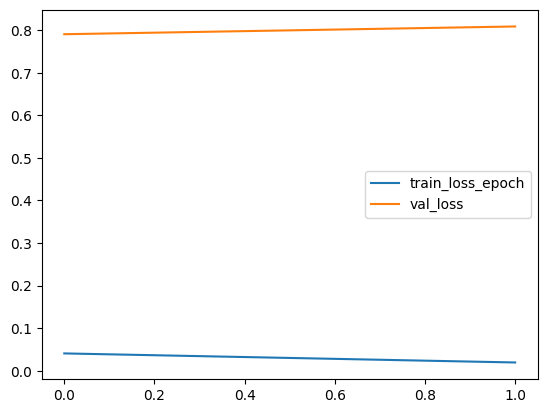

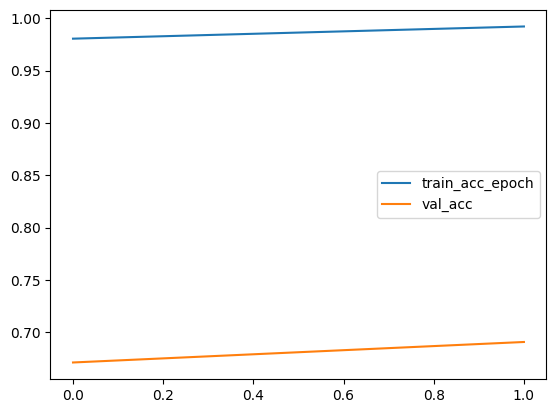

In [80]:
tuning_stats[['train_loss_epoch','val_loss']].plot()
tuning_stats[['train_acc_epoch','val_acc']].plot()

In [81]:
results['t5_ekman'] = test_perm.test_acc.to_list()[0]
results

{'bert_ekman': 0.7224409580230713,
 'bert_goemo': 0.5255905389785767,
 'roberta_ekman': 0.4921259880065918,
 't5_ekman': 0.6397637724876404}

Now we know how to tune T5 based on Ekman scheme. Similarly if we want to tune T5 based on GoEmotion scheme. We first need to fine the expeted output length. 

In [82]:
DATALABEL = 'text'
CLASSLABEL = 'go_label'
output_length = [(e, len(TOKENIZER.encode(e)), TOKENIZER.encode(e)) for e in traindf[CLASSLABEL].unique()]
output_length

[('neutral', 2, [7163, 1]),
 ('anger', 2, [11213, 1]),
 ('fear', 2, [2971, 1]),
 ('annoyance', 5, [3, 24889, 63, 663, 1]),
 ('surprise', 2, [4158, 1]),
 ('gratitude', 2, [17142, 1]),
 ('admiration', 3, [10407, 257, 1]),
 ('confusion', 2, [12413, 1]),
 ('caring', 2, [10328, 1]),
 ('embarrassment', 6, [10960, 10116, 7, 7, 297, 1]),
 ('joy', 2, [3922, 1]),
 ('sadness', 2, [24784, 1]),
 ('disapproval', 4, [1028, 12497, 2165, 1]),
 ('optimism', 2, [24543, 1]),
 ('approval', 2, [5142, 1]),
 ('excitement', 2, [10147, 1]),
 ('amusement', 3, [183, 12431, 1]),
 ('disappointment', 2, [19142, 1]),
 ('remorse', 6, [3, 60, 2528, 7, 15, 1]),
 ('love', 2, [333, 1]),
 ('curiosity', 2, [18967, 1]),
 ('realization', 2, [23543, 1]),
 ('disgust', 2, [27635, 1]),
 ('relief', 2, [4956, 1]),
 ('pride', 2, [6064, 1]),
 ('grief', 2, [17523, 1]),
 ('desire', 2, [3667, 1]),
 ('nervousness', 3, [10045, 655, 1])]

As can be observed, the max length is 6. Let's setup parameters and start tuning.

In [83]:
EPOCH = 2
BATCH_SIZE = 8
LABEL_LENGTH = 6
LEARNING_RATE = 2e-5
MODEL_MAX_LENGTH = TOKENIZER.model_max_length

T5data_goemo = T5DataModule(traindf = traindf, 
                      valdf = valdf, 
                      testdf = testdf, 
                      batch_size = BATCH_SIZE, 
                      tokenizer = TOKENIZER, 
                      text_maxlength = MODEL_MAX_LENGTH, 
                      label_maxlength = LABEL_LENGTH, 
                      datalabel = DATALABEL, 
                      classlabel = CLASSLABEL)
T5data_goemo.setup()

In [84]:
logger = CSVLogger("./logs", name='T5_goemo', version=1)

T5cls_goemo = T5Classifier(model = MODEL, 
                     tokenizer = TOKENIZER, 
                     epoch = EPOCH, 
                     train_size = TRAIN_SIZE, 
                     generated_max_length = LABEL_LENGTH)
trainer = pl.Trainer(
    accelerator="auto", 
    devices="auto",
    max_epochs=EPOCH,
    precision="16-mixed",
    logger=logger)

trainer.fit(T5cls_goemo, T5data_goemo)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\miniconda3\envs\phdenv\Lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [85]:
trainer.test(T5cls_goemo, T5data_goemo)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
e:\miniconda3\envs\phdenv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3937007784843445
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.3937007784843445}]

In [88]:
metrices = pd.read_csv('./logs/T5_goemo/version_1/metrics.csv')
test_perm , tuning_stats = GetTuningStats(metrices)
test_perm


,test_acc
0,0.393701


<Axes: >

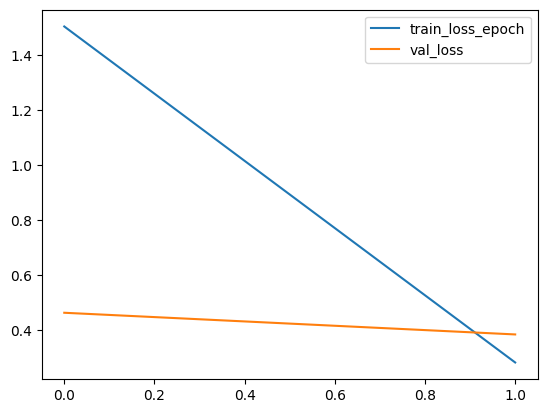

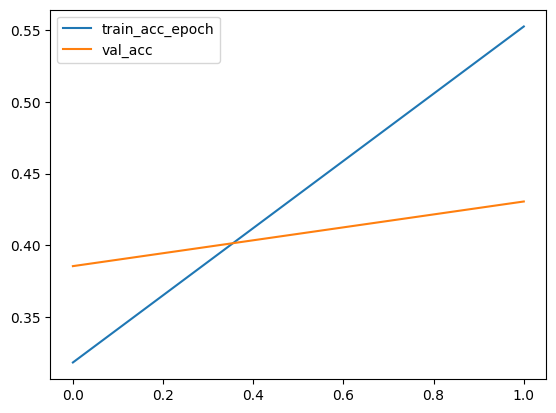

In [89]:
tuning_stats[['train_loss_epoch','val_loss']].plot()
tuning_stats[['train_acc_epoch','val_acc']].plot()

In [90]:
results['t5_goemo'] = test_perm.test_acc.to_list()[0]
results

{'bert_ekman': 0.7224409580230713,
 'bert_goemo': 0.5255905389785767,
 'roberta_ekman': 0.4921259880065918,
 't5_ekman': 0.6397637724876404,
 't5_goemo': 0.3937007784843445}

T5 model can also be saved the same way we save BERT and RoBERTa.

In [91]:
# saving
torch.save(T5cls_goemo.state_dict(), './tuned_models/t5go.pt')

In [93]:
# loading
saved_model = T5Classifier(model = MODEL, 
                     tokenizer = TOKENIZER, 
                     epoch = EPOCH, 
                     train_size = TRAIN_SIZE, 
                     generated_max_length = LABEL_LENGTH
)
saved_model.load_state_dict(torch.load('./tuned_models/t5go.pt'))
saved_model.eval()

T5Classifier(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 512)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 512)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=512, out_features=512, bias=False)
                (k): Linear(in_features=512, out_features=512, bias=False)
                (v): Linear(in_features=512, out_features=512, bias=False)
                (o): Linear(in_features=512, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 8)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=512, out_features=2048, bias=False)
                (wo): Linear(in_feature